In [1]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'../..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import numpy as np
from torch import nn
import torch
import config

from utils import show_abundance, plot_endmembers
from dataset import SyntheticDataset
from HySpecLab.metrics import rmse, sad
from scipy import io as sio

In [2]:
from dataset import SyntheticDatasetType
exp_label = 'snr20'

dataset_type = SyntheticDatasetType.SNR20
result_path = os.path.join(config.RESULTS_PATH, 'syntheticData')

# Image to RGB

In [3]:
from dataset import SyntheticDataset, SyntheticDatasetType
dataset = SyntheticDataset(config.Synthetic_PATH, type=dataset_type ,transform=None)

# matlab_data = {
#     'X': dataset.image(),
#     'n_endmembers': dataset.n_endmembers,
#     'nRow': dataset.n_row,
#     'nCol': dataset.n_col,
#     'nBand': dataset.n_bands
# }

# sio.savemat(os.path.join(result_path, 'matlab/snr10/input.mat'), matlab_data)

In [4]:
jasper_wv = np.linspace(380, 2500, 224, dtype=int) # 224 bands from 380 to 2500 nm

data = sio.loadmat(os.path.join(config.JasperRidge_PATH, 'jasperRidge2_R198.mat'))
selected_bands = data['SlectBands'].squeeze()
selected_jasper_wv = jasper_wv[selected_bands].tolist()

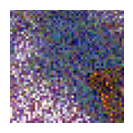

198 (2500, 198)


In [5]:
from HSI2RGB import HSI2RGB

# Use the D65 illuminant
illuminant = 65

# Do minor thresholding
threshold = 0.02
X = dataset.image()
(ydim, xdim, zdim) = X.shape

# Reorder data so that each column holds the spectra of of one pixel
HSI_data = np.reshape(X, [-1,zdim])
rgb = HSI2RGB(selected_jasper_wv, HSI_data, xdim, ydim, illuminant, threshold)

fig = plt.figure(figsize=(7,5))
plt.subplot(3,4,1)
plt.imshow(rgb)
plt.axis('off')
plt.show(fig)

print(len(selected_jasper_wv), HSI_data.shape)

# fig.savefig(os.path.join(result_path, 'clhu/{}/imgs/synthetic_rgb.png'.format(exp_label)), dpi=300, bbox_inches='tight')

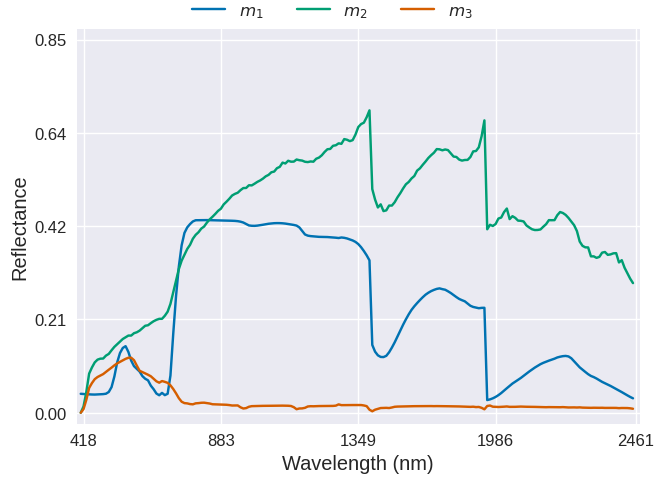

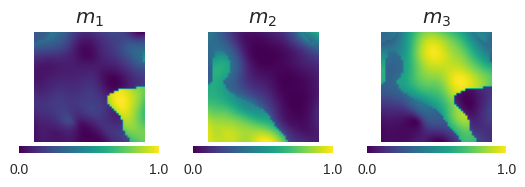

In [6]:
from utils import plot_endmembers, show_abundance
fig = plot_endmembers(dataset.endmembers(), np.array(selected_jasper_wv), ticks_range=(0, .85))
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'clhu/{}/imgs/M_ref.pdf'.format(exp_label)), bbox_inches='tight')

fig = show_abundance(dataset.abundance())
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'clhu/{}/imgs/A_ref.pdf'.format(exp_label)), dpi=300, bbox_inches='tight')

# Endmember estimation

In [7]:
from HySpecLab.metrics import sad

def sort_endmember(endmembers, gt):
    sad_result = sad(endmembers, gt)
    e_idx = torch.argmin(sad_result, dim=0) # Index for reordering the ground truth
    return endmembers[e_idx], e_idx, sad_result

## VCA

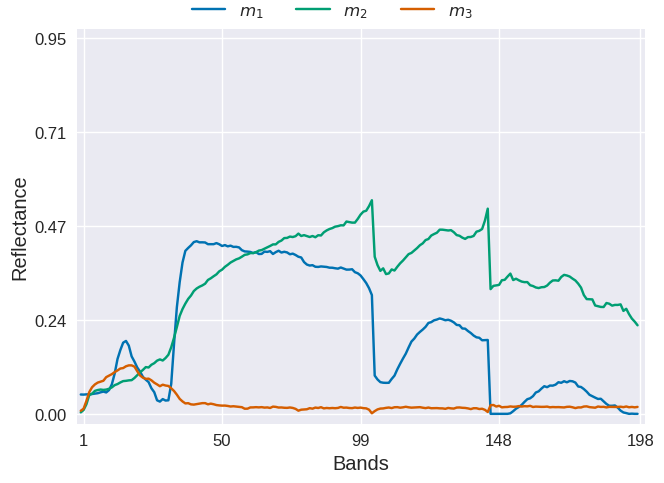

In [8]:
from HySpecLab.eea import VCA
_X = X.reshape(-1, X.shape[-1])
n_endmembers = 3
vca = VCA(n_endmembers, snr_input=30, random_state=25)
vca.fit(_X)
endmembers = torch.from_numpy(vca.endmembers()).float()

vca_endmember_init, _, _ = sort_endmember(endmembers, dataset.endmembers())
vca_logit_endmember_init = torch.log((vca_endmember_init / (1-vca_endmember_init) + 1e-12))

fig = plot_endmembers(vca_endmember_init, ticks_range=(0, .95))
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'clhu/{}/imgs/M_vca.pdf'.format(exp_label)), bbox_inches='tight')

## N-FINDR

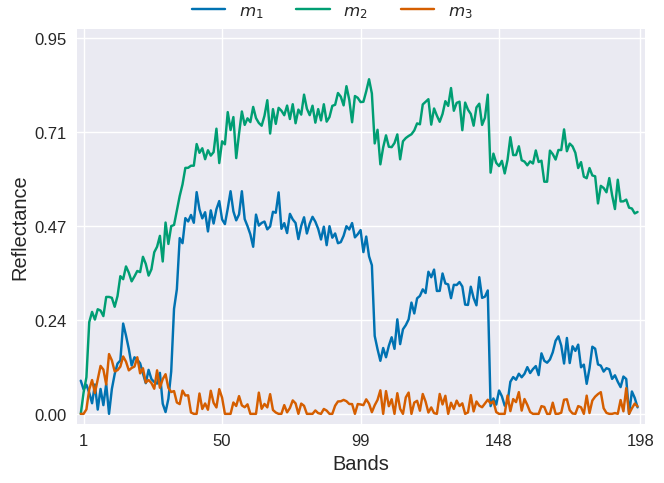

In [9]:
from utils import plot_endmembers
from pysptools import eea
n_endmembers = dataset.n_endmembers

ee = eea.NFINDR()
endmember = torch.from_numpy(ee.extract(X, n_endmembers)).float()

nfindr_endmember_init, _, _ = sort_endmember(endmember, dataset.endmembers())
nfindr_logit_endmember_init = torch.log((nfindr_endmember_init / (1-nfindr_endmember_init) + 1e-12))

fig = plot_endmembers(nfindr_endmember_init, ticks_range=(0, .95))
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'clhu/{}/imgs/M_nfindr.pdf'.format(exp_label)), bbox_inches='tight')

## Plot

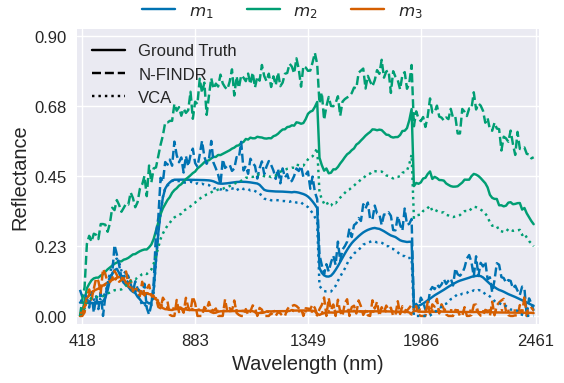

In [10]:
fig = plot_endmembers(dataset.endmembers(), np.array(selected_jasper_wv), ticks_range=(0, .9), figsize=(6,4), endmember_estimation=[nfindr_endmember_init, vca_endmember_init], ee_labels=['Ground Truth', 'N-FINDR', 'VCA'])
plt.show(fig)
# fig.savefig(os.path.join(result_path,  'clhu/{}/imgs/M_estimation.pdf'.format(exp_label)), bbox_inches='tight')

## Select endmembers initialization

In [11]:
# endmember_init_method = 'nfindr'
# endmember_init = nfindr_endmember_init
# logit_endmember_init = nfindr_logit_endmember_init

endmember_init_method = 'vca'
endmember_init = vca_endmember_init
logit_endmember_init = vca_logit_endmember_init

In [12]:
# endmembers_dict = {'NFINDR': endmember_init.numpy(), 'VCA': vca_endmember_init.numpy()}

# sio.savemat(os.path.join(result_path, 'matlab/{}/endmember_estimation.mat'.format(exp_label)), endmembers_dict)

# Training

In [73]:
from utils import train 
from HySpecLab.unmixing import ContrastiveUnmixing

n_bands = dataset.n_bands
model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init, sparsity=1)
# train(model, n_endmembers, dataset, n_batchs=50, n_epochs=50, lr=1e-3, similarity_weight=1, simplex_weight=5e-3)
train(model, n_endmembers, dataset, n_batchs=50, n_epochs=50, lr=1e-3, similarity_weight=1, simplex_weight=0)

  0%|          | 0/50 [00:00<?, ?epoch/s, tls=-1.0000]

100%|██████████| 50/50 [00:21<00:00,  2.34epoch/s, tls=0.1251]


## Saving model

In [74]:
# torch.save(model.state_dict(), os.path.join(result_path, 'clhu/{}/weights/clhu_{}.pth'.format(exp_label, endmember_init_method)))

## Testing model

In [75]:
from HySpecLab.unmixing import ContrastiveUnmixing

# load model
# model = ContrastiveUnmixing(dataset.n_bands, dataset.n_endmembers)

# model.load_state_dict(torch.load(os.path.join(result_path, 'clhu/{}/weights/clhu_{}.pth'.format(exp_label, endmember_init_method))))
model = model.eval()

In [76]:
from HySpecLab.metrics import UnmixingLoss, NormalizedEntropy
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss
criterion = UnmixingLoss()
entropy_reg  = NormalizedEntropy(S=dataset.n_endmembers)
volume_reg = SimplexVolumeLoss(dataset[:], dataset.n_endmembers)
similarity_reg = SimilarityLoss(dataset.n_endmembers, temperature=.1, reduction='mean')

In [77]:
from torch import sigmoid
_X = dataset.X

model.eval()
model = model.cpu()
reconstruc = model(_X)
with torch.no_grad():
    print(criterion(reconstruc, _X).cpu(), entropy_reg(model.A).cpu(), volume_reg(sigmoid(model.ebk)).cpu(),
         similarity_reg(model.ebk).cpu())
        #  similarity_reg(sigmoid(model.ebk)).cpu())

tensor(0.0946) tensor(0.7111) tensor(128.1381) tensor(0.0011)


In [78]:
volume_reg(endmember_init), similarity_reg(logit_endmember_init)

(tensor(18.5025), tensor(0.0144))

## Figures and metrics

Endmember estimation, compared with N-FINDR

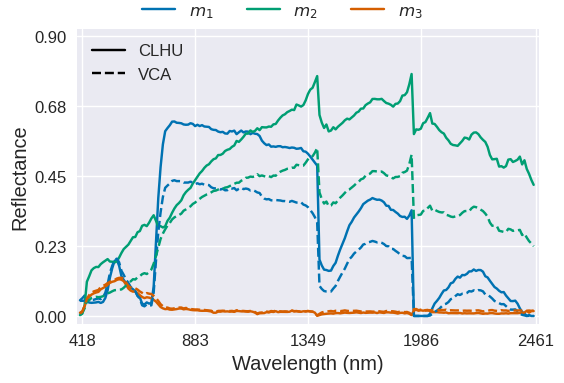

In [79]:
ebk = sigmoid(model.ebk).detach().cpu()
if endmember_init_method == 'vca':
    label = 'VCA'
else:
    label = 'N-FINDR'
fig = plot_endmembers(ebk, np.array(selected_jasper_wv), ticks_range=(0, .9), figsize=(6,4), endmember_estimation=[endmember_init], ee_labels=['CLHU',label])
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'clhu/{}/imgs/{}/M_clhu_estimation.pdf'.format(exp_label, endmember_init_method)), bbox_inches='tight')

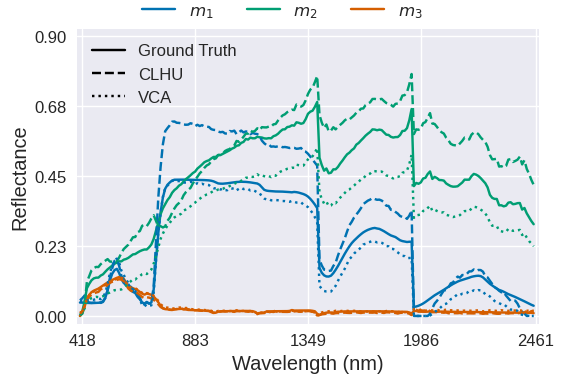

In [80]:
ebk = sigmoid(model.ebk).detach().cpu()
if endmember_init_method == 'vca':
    label = 'VCA'
else:
    label = 'N-FINDR'
fig = plot_endmembers(dataset.endmembers(), np.array(selected_jasper_wv), ticks_range=(0, .9), figsize=(6,4), endmember_estimation=[ebk, endmember_init], ee_labels=['Ground Truth','CLHU',label])
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'clhu/{}/imgs/{}/M_clhu_estimation.pdf'.format(exp_label, endmember_init_method)), bbox_inches='tight')

In [81]:
os.path.join(result_path, 'clhu/{}/imgs/{}/M_clhu_estimation.pdf'.format(exp_label, endmember_init_method))

'/media/abian/Extreme SSD/Thesis/CLHU/review/syntheticData/clhu/snr20/imgs/vca/M_clhu_estimation.pdf'

Abundance Map

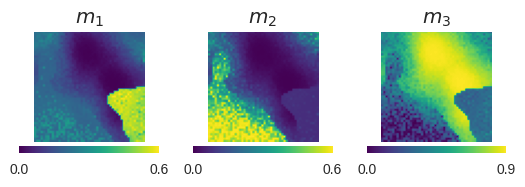

In [82]:
from torch.nn.functional import softmax
test = softmax(model.A.detach(), dim=1).cpu().numpy().reshape(dataset.n_row, dataset.n_col, -1)

fig = show_abundance(test)
plt.show(fig)

# fig.savefig(os.path.join(result_path, 'clhu/{}/imgs/{}/A_clhu_estimation.pdf'.format(exp_label, endmember_init_method)),  bbox_inches='tight')

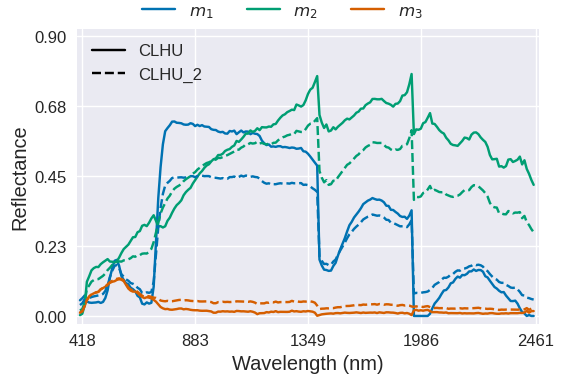

(tensor([[0.0681, 0.5059, 1.1633],
         [0.5676, 0.1239, 1.0895],
         [1.1448, 1.1163, 0.0817]]),
 0.09120067,
 tensor([[0.0723, 0.3764, 1.1067],
         [0.4161, 0.0304, 1.0845],
         [0.7216, 0.6912, 0.4269]]),
 0.17656751)

In [83]:
M = sigmoid(model.ebk).detach().cpu()
M_hat = model(M).detach().cpu()

fig = plot_endmembers(M, np.array(selected_jasper_wv), endmember_estimation=[M_hat], ee_labels=['CLHU', 'CLHU_2'], ticks_range=(0, .9), figsize=(6,4))
plt.show(fig)

sad(M, dataset.endmembers()), np.diagonal(sad(M, dataset.endmembers())).mean(), sad(M_hat, dataset.endmembers()), np.diagonal(sad(M_hat, dataset.endmembers())).mean()

RMSE_X, RMSE_A, SAD_M

In [84]:
X_true = dataset.A @ dataset.endmembers()
X_hat = model(dataset.X).detach().cpu()
A_hat = torch.softmax(model.A.detach().cpu(), dim=1)
M_hat = sigmoid(model.ebk.detach().cpu())

# _M_hat = model(M_hat).detach()

import pandas as pd
df = pd.DataFrame(columns=['Method', 'RMSE_Y', 'RMSE_A', 'SAD_M'])
df['Method'] = ['CLHU']
df['RMSE_Y'] = [rmse(X_true, X_hat, dim=None).numpy()]
df['RMSE_A'] = [rmse(dataset.A, A_hat, dim=None).numpy()]

# sad_result = sad(_M_hat, dataset.endmembers()).numpy()
sad_result = sad(M_hat, dataset.endmembers()).numpy()
df['SAD_M'] = np.diagonal(sad_result).mean()

# df.to_csv(os.path.join(result_path, 'clhu/{}/metrics_{}.csv'.format(exp_label, endmember_init_method)), index=False)
df


,Method,RMSE_Y,RMSE_A,SAD_M
0,CLHU,0.027819853,0.13517497,0.091201


In [233]:
np.diagonal(sad(M_hat, dataset.endmembers())).mean(), np.diagonal(sad(endmember_init, dataset.endmembers())).mean()
# sad(M_hat, dataset.endmembers()), sad(endmember_init, dataset.endmembers())

(0.15983975, 0.15802276)

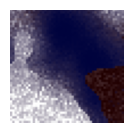

In [234]:
from HSI2RGB import HSI2RGB

# Use the D65 illuminant
illuminant = 65

# Do minor thresholding
threshold = 0.02
_X_hat = X_hat.numpy()
X_hat_img = _X_hat.reshape(dataset.n_row, dataset.n_col, dataset.n_bands, order='F')
(ydim, xdim, zdim) = X_hat_img.shape

# Reorder data so that each column holds the spectra of of one pixel
HSI_data = np.reshape(X_hat_img, [-1,zdim])
rgb = HSI2RGB(selected_jasper_wv, HSI_data, xdim, ydim, illuminant, threshold)

fig = plt.figure(figsize=(7,5))
plt.subplot(3,4,1)
plt.imshow(rgb)
plt.axis('off')
plt.show(fig)

# fig.savefig(os.path.join(result_path, 'clhu/{}/imgs/{}/reconstruction_rgb.png'.format(exp_label,endmember_init_method)), dpi=300, bbox_inches='tight')

# ...

In [235]:
from torch import sigmoid
def test(model, dataset):
    X = dataset.X
    model.eval()
    model = model.cpu()
    
    X_true = dataset.A @ dataset.endmembers()
    with torch.no_grad():
        X_hat = model(dataset.X)
        A_hat = torch.softmax(model.A, dim=1)
        M_hat = sigmoid(model.ebk) 
    
    rmse_x = rmse(X_true, X_hat, dim=None).numpy()      
    rmse_a = rmse(dataset.A, A_hat, dim=None).numpy()
    sad_m = np.diagonal(sad(M_hat, dataset.endmembers()).numpy()).mean()
    return rmse_x.item(), rmse_a.item(), sad_m

In [236]:
from utils import train 
from HySpecLab.unmixing import ContrastiveUnmixing

n_bands = dataset.n_bands

batch_rmse_x = []
batch_rmse_a = []
batch_sad_m = []
for i in range(10):
    model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init)
    train(model, n_endmembers, dataset, n_batchs=50, n_epochs=50, lr=1e-3, similarity_weight=1, simplex_weight=1e-2)

    rmse_x, rmse_a, sad_m = test(model, dataset)
    batch_rmse_x.append(rmse_x)
    batch_rmse_a.append(rmse_a)
    batch_sad_m.append(sad_m)

  0%|          | 0/50 [00:00<?, ?epoch/s, tls=-1.0000]

100%|██████████| 50/50 [00:21<00:00,  2.35epoch/s, tls=0.5640]


In [237]:
# generate dataframe
import pandas as pd
df = pd.DataFrame(columns=['RMSE_X', 'RMSE_A', 'SAD_M'])
df['RMSE_X'] = batch_rmse_x
df['RMSE_A'] = batch_rmse_a
df['SAD_M'] = batch_sad_m

# extract mean and std
df['RMSE_X'].mean(), df['RMSE_X'].std(), df['RMSE_A'].mean(), df['RMSE_A'].std(), df['SAD_M'].mean(), df['SAD_M'].std()

(0.03105625733733177,
 0.0004529953552292537,
 0.07167255282402038,
 0.0019317507690964698,
 0.15859228,
 0.0015666041290387511)

In [238]:
df.to_csv(os.path.join(result_path, 'clhu/{}/metrics_{}_batch.csv'.format(exp_label, endmember_init_method)), index=False)

In [240]:
os.path.join(result_path, 'clhu/{}/metrics_{}_batch.csv'.format(exp_label, endmember_init_method))

'/media/abian/Extreme SSD/Thesis/CLHU/results/syntheticData/clhu/snr10/metrics_vca_batch.csv'

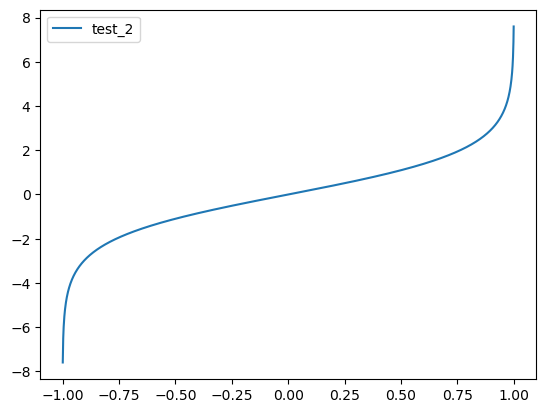

tensor([4.9999e-04, 9.9999e-04, 1.5000e-03,  ..., 9.9850e-01, 9.9900e-01,
        9.9950e-01])

In [42]:
import torch
from matplotlib import pyplot as plt
cos = torch.arange(-0.999, 1, 0.001)

from torch import softmax
test = - torch.log(1 - torch.pow(cos, 2) + 1e-8)
# test_2 = - torch.log(1 - torch.abs(cos) + 1e-8)
cos_2 = (cos * 0.5) + 0.5
test_2 = torch.log((cos_2)/(1 - cos_2 + 1e-8)) 
# test_2 = softmax(test_2, dim=0)
# test = softmax(test, dim=0)
# test_2 = softmax(test_2, dim=0)
# plt.plot(cos, test, label='test')
plt.plot(cos, test_2, label='test_2')
plt.legend()
plt.show()

cos_2


In [29]:
test_2

tensor([nan, nan, nan,  ..., nan, nan, nan])

In [24]:
(-1 * 0.5) + 0.5, (0 * 0.5) + 0.5, (1 * 0.5) + 0.5

(0.0, 0.5, 1.0)

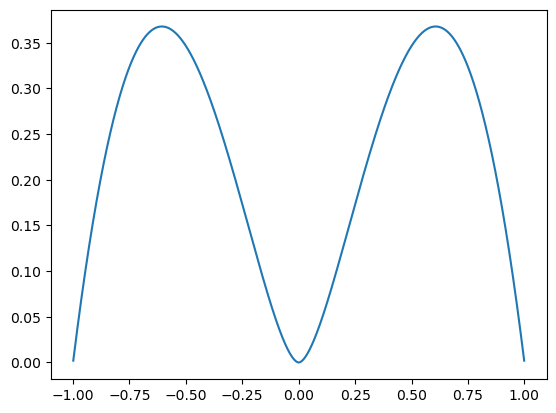

In [8]:
import torch
from matplotlib import pyplot as plt
cos = torch.arange(-0.999, 1, 0.001)

# p = 1 - torch.pow(cos, 2) + 1e-8
p = torch.pow(cos, 2) + 1e-8
test = - p * torch.log(p)
test_2 = - torch.log(p)
# test_2 = - torch.log(1 - torch.abs(cos) + 1e-8)
plt.plot(cos, test)
# plt.plot(cos, test_2)
plt.show()

In [3]:
cos = torch.tensor([1, .2, .01, .1])

cross_entropy = - torch.log(cos[1:]).sum()
cross_entropy

tensor(8.5172)

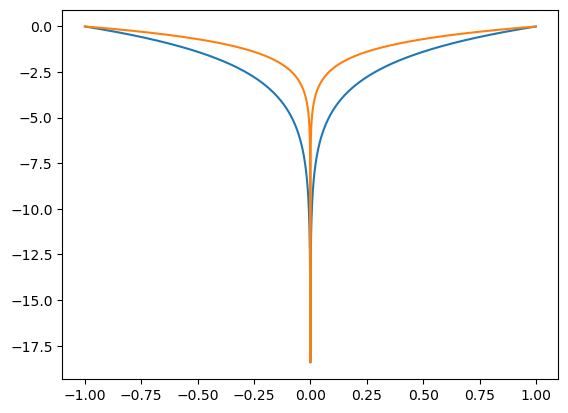

In [4]:
import torch
from matplotlib import pyplot as plt
cos = torch.arange(-0.999, 1, 0.001)


test = torch.log(torch.pow(cos, 2) + 1e-8)
test_2 = torch.log(torch.abs(cos) + 1e-8)
plt.plot(cos, test)
plt.plot(cos, test_2)
plt.show()

In [5]:
from torch.nn.functional import normalize, cross_entropy

X = vca_endmember_init
X = normalize(X, dim=1)
similarity_matrix = torch.softmax(torch.matmul(X, X.T), dim=1)/.1

labels = torch.arange(0, 3).to(X.device)
cross_entropy(similarity_matrix, labels, reduction='mean')

NameError: name 'vca_endmember_init' is not defined

In [ ]:
similarity_matrix

tensor([[4.1830, 3.5787, 2.2382],
        [3.5328, 4.1293, 2.3379],
        [2.5465, 2.6944, 4.7591]])

In [6]:
a = - torch.log(similarity_matrix[0, 1]) - torch.log(similarity_matrix[0, 2])
b = - torch.log(similarity_matrix[1, 0]) - torch.log(similarity_matrix[1, 2])
c = - torch.log(similarity_matrix[2, 0]) - torch.log(similarity_matrix[2, 1])

print(a), print(b), print(c)

(a + b + c)

NameError: name 'similarity_matrix' is not defined

In [63]:
torch.log(similarity_matrix[2, 0]), torch.log(similarity_matrix[2, 1])

(tensor(0.9347), tensor(0.9912))